# Mapping problem using moscot  
from dissociated nPOD scRNAseq data to spatial data  
Dissociated data preprocced by Rebecca Melton from Gaulton's lab 

### Import packages

In [ ]:
!pip install decoupler

In [ ]:
!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [1]:
import time
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
import moscot as mt
#from moscot import datasets
from moscot.problems.space import MappingProblem
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import scanpy as sc
import squidpy as sq

### Data sets

In [2]:
adata = sc.read('/lustre/groups/ml01/datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/scrna/072424_npod_RNA_raw.h5ad')
adata_s1 = sc.read('../../../../../../datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/spatial/S1_annotated_l0.h5ad')

adata, adata_s1

(AnnData object with n_obs × n_vars = 276906 × 36601
     obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1', 'seurat_clusters', 'samples', 'sex', 'condition', 'RNA_snn_res.0.5', 'celltype_assignment1', 'SeuratClusters', 'celltype_assignment2', 'barcode', 'nPOD_barcode', 'CurrentObjLabels', 'nPOD_ID', 'technology', 'nCount_RAW_mtx', 'nFeature_RAW_mtx', 'conditionSubtype', 'CellTypes'
     var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
     obsm: 'X_harmony', 'X_pca', 'X_umap'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 108711 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_

In [3]:
adata.obs['CellTypes'].cat.categories

Index(['Acinar_basal', 'Acinar_highEnz', 'Acinar_sigdiff', 'Acinar_signal',
       'Activated_Stellate', 'Alpha', 'Bcells', 'Beta', 'Delta', 'Ductal',
       'Endothelial', 'LymphEndo', 'MUC5b_Ductal', 'Macrophage', 'Mast',
       'Quiescent_Stellate', 'Schwann', 'Tcells'],
      dtype='object')

### Subsetting and pre-processing

Rebecca's filtering criteria: for each cell type we excluded donors with fewer than 20 cells in that cell type and then excluded any cell type from analysis if there was not at least 2 non-diabetic and 2 disease condition donors.

In [4]:
# Step 1: Calculate counts of CellTypes per nPOD_ID
celltype_counts = adata.obs.groupby(['nPOD_ID', 'CellTypes']).size().reset_index(name='counts')
# Step 2: Identify groups with fewer than 20 observations
filtered_counts = celltype_counts[celltype_counts['counts'] >= 20]
# Step 3: Keep only observations from filtered nPOD_ID and CellTypes combinations
valid_combinations = set(zip(filtered_counts['nPOD_ID'], filtered_counts['CellTypes']))
filtered_adata = adata[adata.obs.apply(lambda row: (row['nPOD_ID'], row['CellTypes']) in valid_combinations, axis=1)]

# Step 1: Calculate counts of each 'condition' per 'CellTypes'
condition_counts = filtered_adata.obs.groupby(['CellTypes', 'condition']).size().unstack(fill_value=0)

# Step 2: Identify 'CellTypes' that do not meet the specified criteria
# Criteria: 
# - Count of 'Aab' and 'Control' should be at least 2 each
# - Count of 'T1D' should be at least 2

invalid_celltypes = condition_counts[
    (condition_counts['Aab'] < 2) |
    (condition_counts['Control'] < 2) |
    (condition_counts['T1D'] < 2)
].index

# Step 3: Filter the AnnData object to remove invalid 'CellTypes'
adata_sc = filtered_adata[~filtered_adata.obs['CellTypes'].isin(invalid_celltypes)]
adata_sc

View of AnnData object with n_obs × n_vars = 274947 × 36601
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1', 'seurat_clusters', 'samples', 'sex', 'condition', 'RNA_snn_res.0.5', 'celltype_assignment1', 'SeuratClusters', 'celltype_assignment2', 'barcode', 'nPOD_barcode', 'CurrentObjLabels', 'nPOD_ID', 'technology', 'nCount_RAW_mtx', 'nFeature_RAW_mtx', 'conditionSubtype', 'CellTypes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

In [5]:
adata_s1.uns['cell_type_coarse_colors'] = [
    '#edd892', #acinar
    '#219ebc', #alpha
    '#adc178', #beta
    '#f79824', #ductal
    '#718355', #endocrine
    '#f15156', #endothelial
    '#bbd0ff', #Fibroblasts
    '#979dac', #Immune
    '#582f0e'  #mast
]

In [6]:
sq.pl.spatial_segment(adata_s1,color='cell_type_coarse',ncols=2,library_id=['10','12'],
                      library_key='fov', seg_cell_id='cell_ID',img=False)

In [7]:
adata_sc.uns['CellTypes_colors'] = [
    '#4FB3AA',#'Acinar_basal'
    '#005F73',#'Acinar_highEnz', 
    '#0A9396',#'Acinar_sigdiff', 
    '#5FD3CF',#'Acinar_signal',
    '#e07a5f',#'Activated_Stellate', 
    '#b5838d',#'Alpha', 
    #'#f8ad9d',#'Bcells', 
    '#ffd6ff',#'Beta', 
    '#c8b6ff',#'Delta', 
    '#bde0fe',#'Ductal',
    '#f2cc8f',#'Endothelial', 
    #'#ffa62b',#'LymphEndo', 
    '#6096ba',#'MUC5b_Ductal', 
    '#8d0801',#'Macrophage', 
    #'#4f000b',#'Mast',
    '#ff7f51',#'Quiescent_Stellate', 
    #'#ce4257',#'Schwann', 
    '#e5383b',#'Tcells'
]

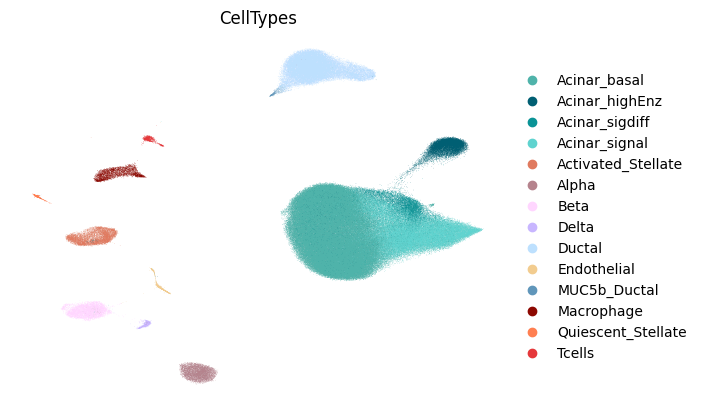

In [8]:
sc.pl.umap(adata_sc, color='CellTypes',frameon=False)

In [9]:
sc.pl.umap(adata_sc, color=['INS','GCG','CHGA'],frameon=False,cmap='Greys')

In [10]:
sc.pp.highly_variable_genes(
    adata_sc,
    n_top_genes=5000,
    subset=True,
    #layer='counts',
    #batch_key='nPOD_ID'#when using sample --> INS isn't kept 
)
adata_sc

AnnData object with n_obs × n_vars = 274947 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.1', 'seurat_clusters', 'samples', 'sex', 'condition', 'RNA_snn_res.0.5', 'celltype_assignment1', 'SeuratClusters', 'celltype_assignment2', 'barcode', 'nPOD_barcode', 'CurrentObjLabels', 'nPOD_ID', 'technology', 'nCount_RAW_mtx', 'nFeature_RAW_mtx', 'conditionSubtype', 'CellTypes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CellTypes_colors', 'hvg'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

Pseudobulk dissociated data

In [11]:
import decoupler as dc

In [12]:
# Get filtered pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata_sc,
    sample_col='samples',
    groups_col='CellTypes',
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)
pdata

AnnData object with n_obs × n_vars = 432 × 5000
    obs: 'samples', 'sex', 'condition', 'CurrentObjLabels', 'nPOD_ID', 'technology', 'conditionSubtype', 'CellTypes', 'psbulk_n_cells', 'psbulk_counts'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'psbulk_props'

In [13]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
#dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

In [14]:
adata_sc.obs['CellTypes'].cat.categories

Index(['Acinar_basal', 'Acinar_highEnz', 'Acinar_sigdiff', 'Acinar_signal',
       'Activated_Stellate', 'Alpha', 'Beta', 'Delta', 'Ductal', 'Endothelial',
       'MUC5b_Ductal', 'Macrophage', 'Quiescent_Stellate', 'Tcells'],
      dtype='object')

In [15]:
pdata.uns['CellTypes_colors'] = [
    '#4FB3AA',#'Acinar_basal'
    '#005F73',#'Acinar_highEnz', 
    '#0A9396',#'Acinar_sigdiff', 
    '#5FD3CF',#'Acinar_signal',
    '#e07a5f',#'Activated_Stellate', 
    '#b5838d',#'Alpha', 
    #'#f8ad9d',#'Bcells', 
    '#ffd6ff',#'Beta', 
    '#c8b6ff',#'Delta', 
    '#bde0fe',#'Ductal',
    '#f2cc8f',#'Endothelial', 
    '#ffa62b',#'LymphEndo', 
    '#6096ba',#'MUC5b_Ductal', 
    '#8d0801',#'Macrophage', 
    '#4f000b',#'Mast',
    '#ff7f51',#'Quiescent_Stellate', 
    #'#ce4257',#'Schwann', 
    '#e5383b',#'Tcells'
]

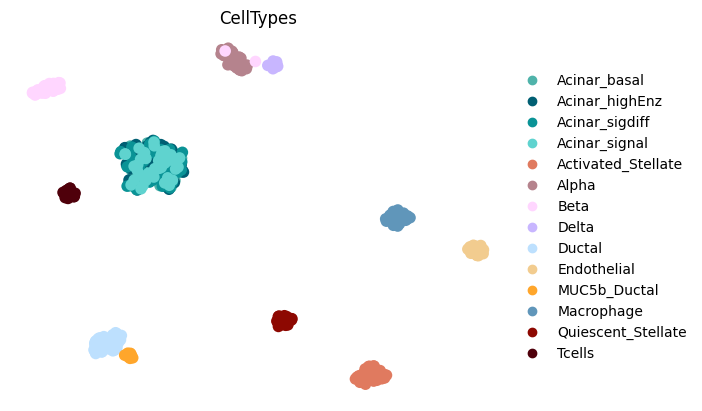

In [16]:
sc.pp.neighbors(pdata)
sc.tl.umap(pdata)
sc.pl.umap(pdata, color='CellTypes', frameon=False)

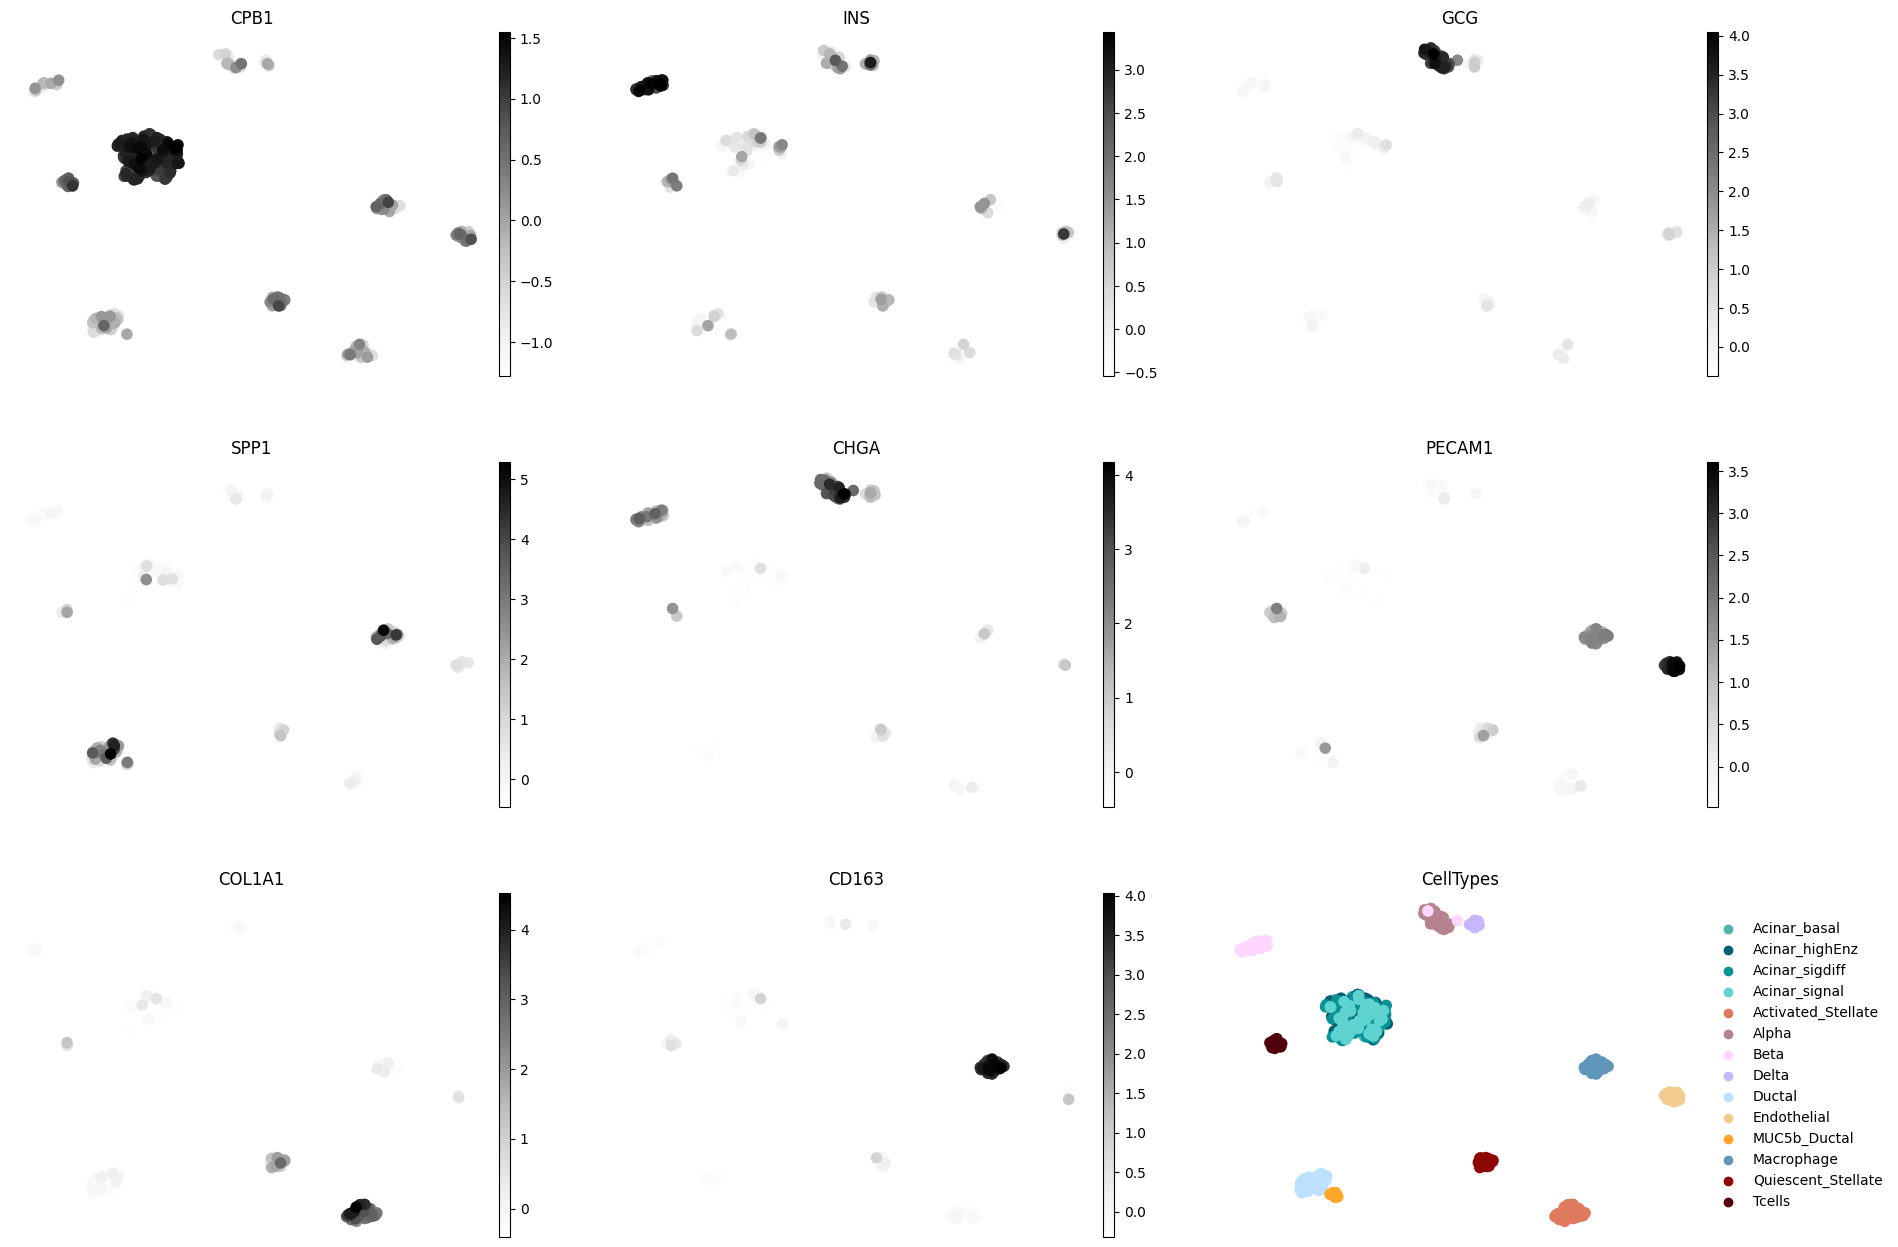

In [17]:
# 'CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163'
sc.pl.umap(pdata,color=['CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163','CellTypes'],
          ncols=3,cmap='Greys',frameon=False)

In [18]:
adata_s1

AnnData object with n_obs × n_vars = 108711 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'cell_type_coarse_colors'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

### Subset to FOVs and pre-process

In [19]:
adata_10 = adata_s1[np.isin(adata_s1.obs['fov'],['10'])].copy()
adata_12 = adata_s1[np.isin(adata_s1.obs['fov'],['12'])].copy()

adata_10, adata_12

(AnnData object with n_obs × n_vars = 4423 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'log1p', 'spatial', 'cell_type_coarse_colors'
     obsm: 'spatial', 'spatial_fov'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 5208 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_g

In [20]:
sc.pp.pca(adata_10)
sc.pp.neighbors(adata_10)
sc.tl.umap(adata_10)

sc.pp.pca(adata_12)
sc.pp.neighbors(adata_12)
sc.tl.umap(adata_12)

### Preprare and solve the mapping problem 

In [21]:
genes = pd.read_csv('../../../../spatial_pancreas_data/preprocessed_data/genes2impute.txt', delimiter='\t', header=None)
genes2impute = list(genes[(np.isin(genes[0],adata_sc.var_names))][0])
control_markers = pd.DataFrame(['CPB1','INS','GCG','SPP1','CHGA','PECAM1','COL1A1','CD163'])
markers2impute = list(control_markers[np.isin(control_markers,adata_sc.var_names)][0])
genes2impute = genes2impute + markers2impute

In [22]:
markers2impute

['CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163']

In [23]:
# Leave the control genes out of the fitting
adata_10_mp = adata_10[:,~adata_10.var_names.isin(markers2impute)].copy()
adata_12_mp = adata_12[:,~adata_12.var_names.isin(markers2impute)].copy()

In [27]:
params = {
    'epsilon': [0.01,0.05,0.1],#[0.05, 0.1], #0.01 default 
    'alpha': [0.2,0.3,0.4,0.5],#[0.2,0.3], #0.5 default
    'tau_a': [0.999, 0.995, 0.990, 0.900],#[1, 0.999, 0.995, 0.990, 0.900], #0.990 default
    'tau_b': [0.999, 0.995, 0.990, 0.900]#[1, 0.999, 0.995, 0.990, 0.900] #0.990 default
}

In [28]:
from sklearn.metrics import f1_score

In [ ]:
evaluation = []
for tau_a in params['tau_a']:
    for tau_b in params['tau_b']:
        for alpha in params['alpha']:
            for epsilon in params['epsilon']:
                
                #prepare mapping problem
                mp = MappingProblem(adata_sc=pdata, adata_sp=adata_10_mp)
                mp = mp.prepare(
                    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
                    callback="local-pca" if adata_10.shape[1] > 100 else None,
                    kwargs = {'callback_kwargs': 'local_pca','joint-space': True},
                    spatial_key = {'attr': 'obsm', 'key': 'X_pca'},
                    cost = 'cosine',#'cosine', #'sq_euclidean', 
                    joint_attr = {'attr':'X'}, #'X_pca' {'attr':'X_pca'}
                )
                #solve mapping problem 
                mp = mp.solve(alpha=alpha,epsilon=epsilon,tau_a=tau_a,tau_b=tau_b)
                
                #evaluating the mapping problem through imputation
                adata_imputed = mp.impute(var_names=genes2impute)
                correlations_hallmark_genes = []

                for i in markers2impute:
                    gene = i
                    obs_genes = adata_10[:,[gene]].X.copy().toarray().flatten()
                    imp_genes = adata_imputed[:,[gene]].X.copy().flatten()
                    correlation, p_value = pearsonr(obs_genes, imp_genes)
                    row_data = {
                        'gene' : gene,
                        'Pearson_correlation' : correlation,
                        'P_value' : p_value
                    }
                    correlations_hallmark_genes.append(row_data)
                
                df = pd.DataFrame(correlations_hallmark_genes)
                #'CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163'
                #print('-----------------------------------------------------------') 
                row_data = {
                    'tau_a' : tau_a,
                    'tau_b' : tau_b,
                    'alpha' : alpha,
                    'epsilon' : epsilon, 
                    'cpb1_corr' : df.loc[df['gene'] == 'CPB1', 'Pearson_correlation'].values[0],
                    'ins_corr' : df.loc[df['gene'] == 'INS', 'Pearson_correlation'].values[0],
                    'gcg_corr' : df.loc[df['gene'] == 'GCG', 'Pearson_correlation'].values[0],
                    'spp1_corr' : df.loc[df['gene'] == 'SPP1', 'Pearson_correlation'].values[0],
                    'chga_corr' : df.loc[df['gene'] == 'CHGA', 'Pearson_correlation'].values[0],
                    'pecam1_corr' : df.loc[df['gene'] == 'PECAM1', 'Pearson_correlation'].values[0],
                    'col1a1_corr' : df.loc[df['gene'] == 'COL1A1', 'Pearson_correlation'].values[0],
                    'cd163_corr' : df.loc[df['gene'] == 'CD163', 'Pearson_correlation'].values[0],
                    'mean_corr' : df['Pearson_correlation'].mean()
                }
                evaluation.append(row_data)
                del mp
                del adata_imputed
df_10 = pd.DataFrame(evaluation)
df_10

In [ ]:
evaluation = []
for tau_a in params['tau_a']:
    for tau_b in params['tau_b']:
        for alpha in params['alpha']:
            for epsilon in params['epsilon']:
                
                #prepare mapping problem
                mp = MappingProblem(adata_sc=pdata, adata_sp=adata_12_mp)
                mp = mp.prepare(
                    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
                    callback="local-pca" if adata_12.shape[1] > 100 else None,
                    kwargs = {'callback_kwargs': 'local_pca','joint-space': True},
                    spatial_key = {'attr': 'obsm', 'key': 'X_pca'},
                    cost = 'cosine',#'cosine', #'sq_euclidean', 
                    joint_attr = {'attr':'X'}, #'X_pca' {'attr':'X_pca'}
                )
                #solve mapping problem 
                mp = mp.solve(alpha=alpha,epsilon=epsilon,tau_a=tau_a,tau_b=tau_b)
                
                #evaluating the mapping problem through imputation
                adata_imputed = mp.impute(var_names=genes2impute)
                correlations_hallmark_genes = []

                for i in markers2impute:
                    gene = i
                    obs_genes = adata_12[:,[gene]].X.copy().toarray().flatten()
                    imp_genes = adata_imputed[:,[gene]].X.copy().flatten()
                    correlation, p_value = pearsonr(obs_genes, imp_genes)
                    row_data = {
                        'gene' : gene,
                        'Pearson_correlation' : correlation,
                        'P_value' : p_value
                    }
                    correlations_hallmark_genes.append(row_data)
                
                df = pd.DataFrame(correlations_hallmark_genes)
                #'CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163'
                #print('-----------------------------------------------------------') 
                row_data = {
                    'tau_a' : tau_a,
                    'tau_b' : tau_b,
                    'alpha' : alpha,
                    'epsilon' : epsilon, 
                    'cpb1_corr' : df.loc[df['gene'] == 'CPB1', 'Pearson_correlation'].values[0],
                    'ins_corr' : df.loc[df['gene'] == 'INS', 'Pearson_correlation'].values[0],
                    'gcg_corr' : df.loc[df['gene'] == 'GCG', 'Pearson_correlation'].values[0],
                    'spp1_corr' : df.loc[df['gene'] == 'SPP1', 'Pearson_correlation'].values[0],
                    'chga_corr' : df.loc[df['gene'] == 'CHGA', 'Pearson_correlation'].values[0],
                    'pecam1_corr' : df.loc[df['gene'] == 'PECAM1', 'Pearson_correlation'].values[0],
                    'col1a1_corr' : df.loc[df['gene'] == 'COL1A1', 'Pearson_correlation'].values[0],
                    'cd163_corr' : df.loc[df['gene'] == 'CD163', 'Pearson_correlation'].values[0],
                    'mean_corr' : df['Pearson_correlation'].mean()
                }
                evaluation.append(row_data)
                del mp
                del adata_imputed
df_12 = pd.DataFrame(evaluation)
df_12

In [ ]:
# Find the index label corresponding to the maximum value in a specific column
max_index_10 = df_10['mean_corr'].idxmax()

# Retrieve the values of the row with the maximum value in the column
max_row_values_10 = df_10.loc[max_index_10]

# Print the values
print(max_row_values_10)

In [ ]:
# Find the index label corresponding to the maximum value in a specific column
max_index_12 = df_12['mean_corr'].idxmax()

# Retrieve the values of the row with the maximum value in the column
max_row_values_12 = df_12.loc[max_index_12]

# Print the values
print(max_row_values_12)

### Analysis of the transport plan with the best set of found parameters

In [24]:
best_param_10 = {
    'epsilon': 0.1,
    'alpha': 0.5,
    'tau_a': 0.995,
    'tau_b': 0.9
}

best_param_12 = {
    'epsilon': 0.1,
    'alpha': 0.5,
    'tau_a': 0.99,
    'tau_b': 0.9
}

In [ ]:
best_param_10 = max_row_values_10.to_dict()
best_param_12 = max_row_values_12.to_dict()
best_param_10, best_param_12

In [25]:
mp_10 = MappingProblem(adata_sc=pdata, adata_sp=adata_10)
mp_10 = mp_10.prepare(
    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
    callback="local-pca" if adata_10.shape[1] > 100 else None,
    kwargs = {'callback_kwargs': 'local_pca', 'joint-space': True},
    spatial_key = {'attr': 'obsm', 'key': 'X_pca'},
    cost = 'cosine', #'sq_euclidean', 
    joint_attr = {"attr":"X"} #'X_pca' {'attr':'X_pca'}
)
#solve mapping problem 
mp_10 = mp_10.solve(alpha=best_param_10['alpha'],epsilon=best_param_10['epsilon'],tau_a=best_param_10['tau_a'],tau_b=best_param_10['tau_b'])

mp_12 = MappingProblem(adata_sc=pdata, adata_sp=adata_12)
mp_12 = mp_12.prepare(
    sc_attr = {'attr': 'obsm', 'key': 'X_pca'}, 
    callback="local-pca" if adata_12.shape[1] > 100 else None,
    kwargs = {'callback_kwargs': 'local_pca', 'joint-space': True},
    spatial_key = {'attr': 'obsm', 'key': 'X_pca'},
    cost = 'cosine', #'sq_euclidean', 
    joint_attr = {"attr":"X"} #'X_pca' {'attr':'X_pca'}
)
#solve mapping problem 
mp_12 = mp_12.solve(alpha=best_param_12['alpha'],epsilon=best_param_12['epsilon'],tau_a=best_param_12['tau_a'],tau_b=best_param_12['tau_b'])

INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(4423, 432)].                                           


2024-08-27 14:27:05.253686: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


INFO     Normalizing spatial coordinates of `x`.                                                                   
WARNING  Densifying data in `adata.X`                                                                              
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(5208, 432)].                                           


#### Imputation

In [26]:
# impute the 5k HVG from sc data 

start_time = time.time()

adatas_imputed_10 = []
for i in range(int(len(pdata.var_names)/20)):
    adata_imputed_10 = mp_10.impute(var_names=pdata.var_names[i*20:i*20+20],device='cuda:0')
    adatas_imputed_10.append(adata_imputed_10)
    del adata_imputed_10

adatas_imputed_12 = []
for i in range(int(len(pdata.var_names)/20)):
    adata_imputed_12 = mp_12.impute(var_names=pdata.var_names[i*20:i*20+20],device='cuda:0')
    adatas_imputed_12.append(adata_imputed_12)
    del adata_imputed_12

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 31.565217971801758 seconds


In [27]:
import anndata as ad
adata_imputed_10  = ad.concat(adatas_imputed_10, join='outer',uns_merge='same',axis=1)
adata_imputed_12  = ad.concat(adatas_imputed_12, join='outer',uns_merge='same',axis=1)

adata_imputed_10, adata_imputed_12

(AnnData object with n_obs × n_vars = 4423 × 5000,
 AnnData object with n_obs × n_vars = 5208 × 5000)

In [28]:
adata_10, adata_12

(AnnData object with n_obs × n_vars = 4423 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'pca', 'neighbors', 'umap'
     obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'counts'
     obsp: 'distances', 'connectivit

In [29]:
adata_imputed_10.uns['spatial'] = adata_10.uns['spatial']
adata_imputed_10.obsm['spatial'] = adata_10.obsm['spatial']
adata_imputed_10.obs['fov'] = adata_10.obs['fov']
adata_imputed_10.obs['cell_ID'] = adata_10.obs['cell_ID']  

adata_imputed_12.uns['spatial'] = adata_12.uns['spatial']
adata_imputed_12.obsm['spatial'] = adata_12.obsm['spatial']
adata_imputed_12.obs['fov'] = adata_12.obs['fov']
adata_imputed_12.obs['cell_ID'] = adata_12.obs['cell_ID']  

adata_imputed_10, adata_imputed_12

(AnnData object with n_obs × n_vars = 4423 × 5000
     obs: 'fov', 'cell_ID'
     uns: 'spatial'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 5208 × 5000
     obs: 'fov', 'cell_ID'
     uns: 'spatial'
     obsm: 'spatial')

Plotting imputed gene expression

In [30]:
markers2impute

['CPB1', 'INS', 'GCG', 'SPP1', 'CHGA', 'PECAM1', 'COL1A1', 'CD163']

In [31]:
sq.pl.spatial_segment(adata_imputed_10,color=markers2impute,ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='Greys', img=False)

In [32]:
sq.pl.spatial_segment(adata_imputed_12,color=markers2impute,ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='Greys', img=False)

#### Annotation mapping

In [37]:
mp_10[("src", "tgt")], mp_10

(OTProblem[stage='solved', shape=(4423, 432)], MappingProblem[('src', 'tgt')])

In [34]:
mp_12[("src", "tgt")]

OTProblem[stage='solved', shape=(5208, 432)]

In [35]:
type(pdata.obs.CellTypes)

pandas.core.series.Series

In [38]:
pdata.obs.cell_type = pdata.obs.CellTypes.astype("category")

Annotation mapping using “max” mode

In [39]:
start_time = time.time()

anno_map_max_10 = mp_10.annotation_mapping(
    "max",
    "CellTypes",
    source="src",
    #target="tgt",
    forward=False,
    batch_size=256,
)

anno_map_max_12 = mp_12.annotation_mapping(
    "max",
    "CellTypes",
    source="src",
    #target="tgt",
    forward=False,
    batch_size=256,
)

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

Execution time: 26.733413219451904 seconds


In [40]:
adata_10.obs["CellTypes_max"] = anno_map_max_10["CellTypes"].values
adata_10.obs["CellTypes_max"] = adata_10.obs["CellTypes_max"].astype("category")

adata_12.obs["CellTypes_max"] = anno_map_max_12["CellTypes"].values
adata_12.obs["CellTypes_max"] = adata_12.obs["CellTypes_max"].astype("category")

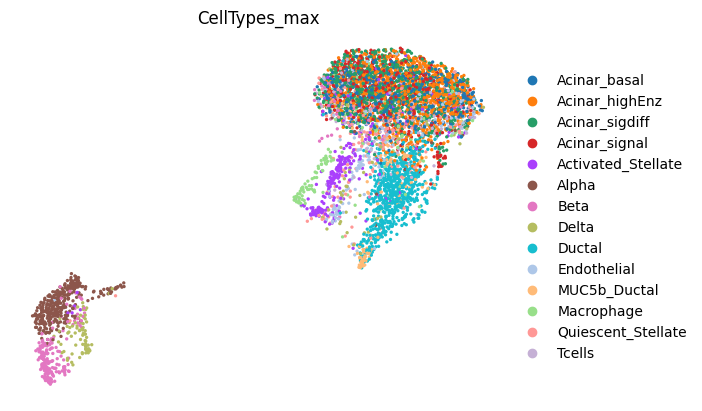

In [41]:
#sc.pl.umap(adata_sc, color="cell_type")
sc.pl.umap(adata_10, color=["CellTypes_max"], frameon=False)
sc.pl.umap(adata_12, color=["CellTypes_max"], frameon=False)

In [43]:
adata_10.uns['CellTypes_max_colors'] = [
    '#4FB3AA',#'Acinar_basal'
    '#005F73',#'Acinar_highEnz', 
    '#0A9396',#'Acinar_sigdiff', 
    '#5FD3CF',#'Acinar_signal',
    '#e07a5f',#'Activated_Stellate', 
    '#b5838d',#'Alpha', 
    #'#f8ad9d',#'Bcells', 
    '#ffd6ff',#'Beta', 
    '#c8b6ff',#'Delta', 
    '#bde0fe',#'Ductal',
    '#f2cc8f',#'Endothelial', 
    #'#ffa62b',#'LymphEndo', 
    '#6096ba',#'MUC5b_Ductal', 
    '#8d0801',#'Macrophage', 
    #'#4f000b',#'Mast',
    '#ff7f51',#'Quiescent_Stellate', 
    #'#ce4257',#'Schwann', 
    '#e5383b',#'Tcells'
]

adata_12.uns['CellTypes_max_colors'] = [
    '#4FB3AA',#'Acinar_basal'
    '#005F73',#'Acinar_highEnz', 
    '#0A9396',#'Acinar_sigdiff', 
    '#5FD3CF',#'Acinar_signal',
    '#e07a5f',#'Activated_Stellate', 
    '#b5838d',#'Alpha', 
    #'#f8ad9d',#'Bcells', 
    '#ffd6ff',#'Beta', 
    '#c8b6ff',#'Delta', 
    '#bde0fe',#'Ductal',
    '#f2cc8f',#'Endothelial', 
    #'#ffa62b',#'LymphEndo', 
    '#6096ba',#'MUC5b_Ductal', 
    '#8d0801',#'Macrophage', 
    #'#4f000b',#'Mast',
    '#ff7f51',#'Quiescent_Stellate', 
    #'#ce4257',#'Schwann', 
    '#e5383b',#'Tcells'
]

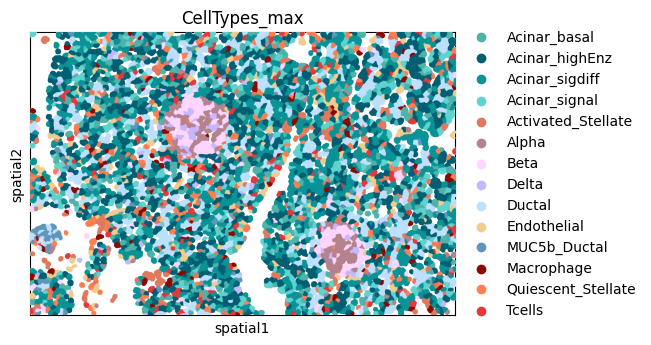

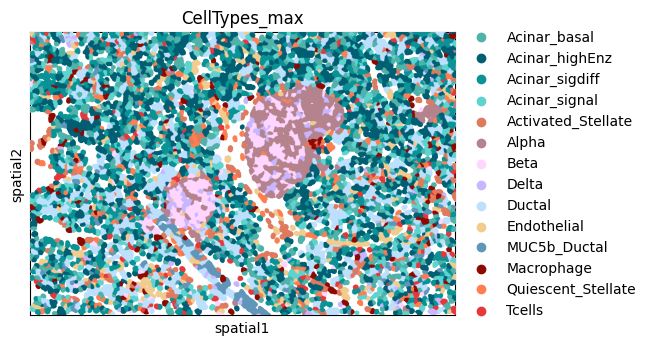

In [44]:
sq.pl.spatial_segment(adata_10,color='CellTypes_max',size=5,library_key='fov', seg_cell_id='cell_ID', img=False)

sq.pl.spatial_segment(adata_12,color='CellTypes_max',size=5,library_key='fov', seg_cell_id='cell_ID', img=False)

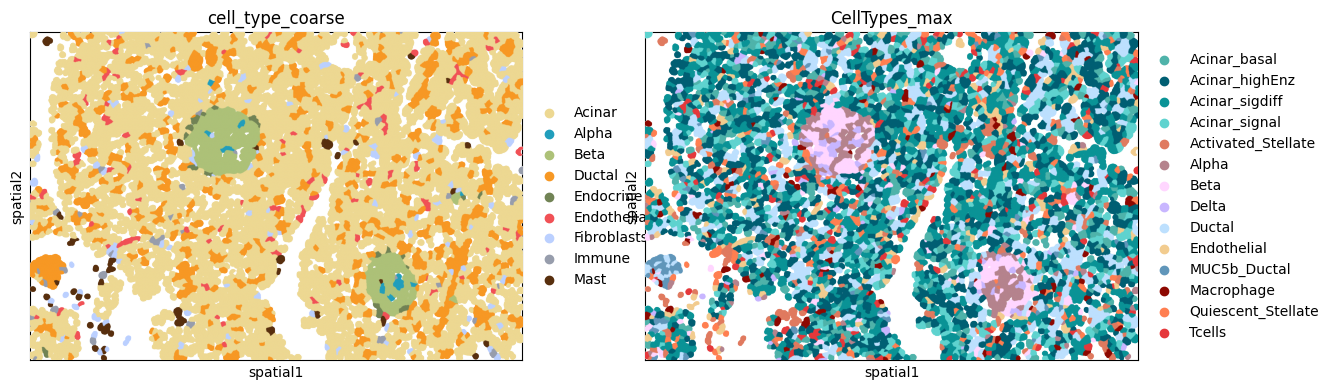

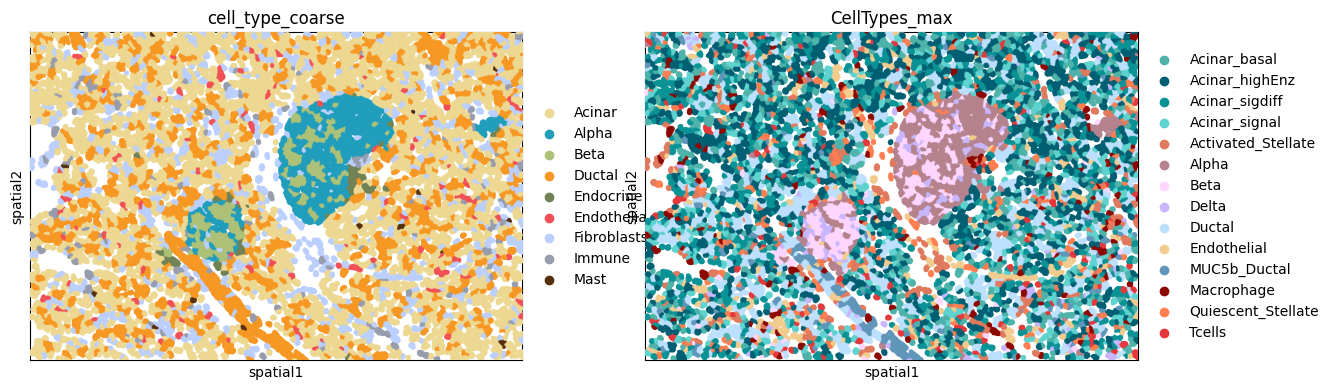

In [45]:
sq.pl.spatial_segment(adata_10,color=['cell_type_coarse','CellTypes_max'],size=5,ncols=2,library_key='fov', seg_cell_id='cell_ID',img=False)
sq.pl.spatial_segment(adata_12,color=['cell_type_coarse','CellTypes_max'],size=5,ncols=2,library_key='fov', seg_cell_id='cell_ID',img=False)

In [46]:
adata_10, adata_12

(AnnData object with n_obs × n_vars = 4423 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'log1p', 'spatial', 'cell_type_coarse_colors', 'pca', 'neighbors', 'umap', 'CellTypes_max_colors'
     obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'cou

In [47]:
folder = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'

adata_10.write(folder+'adata_fov_10_npod_annotation_filtered.h5ad')
adata_12.write(folder+'adata_fov_12_npod_annotation_filtered.h5ad')

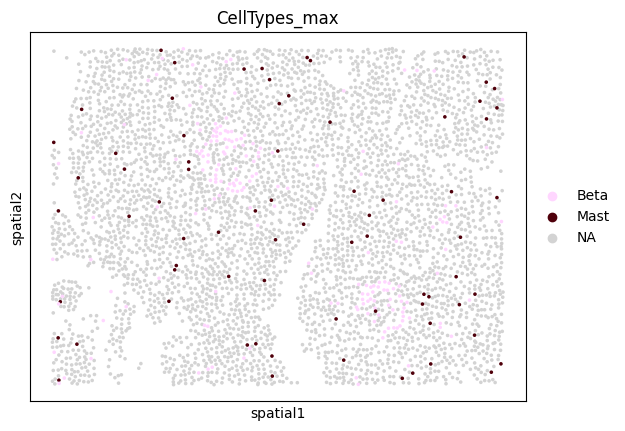

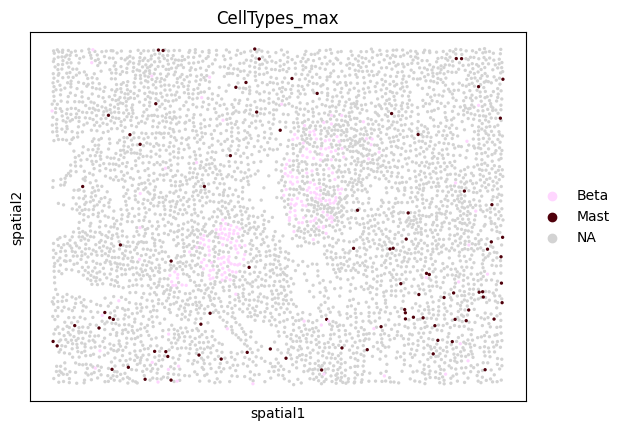

In [51]:
sc.pl.embedding(adata_10,color=['CellTypes_max'],groups=['Beta','Mast'],basis='spatial')
sc.pl.embedding(adata_12,color=['CellTypes_max'],groups=['Beta','Mast'],basis='spatial')

In [57]:
sq.gr.spatial_neighbors(
    adata_sp_fov_12,
    n_neighs=15,
    coord_type="generic",
    delaunay=True,
)

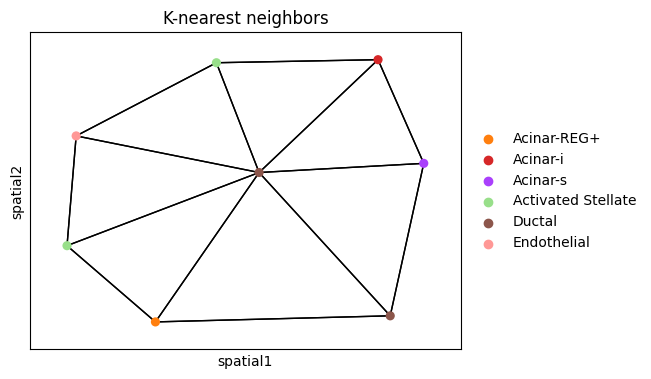

In [58]:
_, idx = adata_sp_fov_12.obsp["spatial_connectivities"][420, :].nonzero()
idx = np.append(idx, 420)
sq.pl.spatial_scatter(
    adata_sp_fov_12[idx,420],
    library_id = '12',
    color="Cluster_max",
    connectivity_key="spatial_connectivities",
    size=3,
    edges_width=1,
    edges_color="black",
    img=False,
    title="K-nearest neighbors"
)

In [59]:
sq.gr.nhood_enrichment(adata_sp_fov_12,cluster_key='Cluster_max')

  0%|          | 0/1000 [00:00<?, ?/s]/home/aih/sara.jimenez/miniconda3/envs/moscot_v2/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1000/1000 [00:01<00:00, 848.79/s]


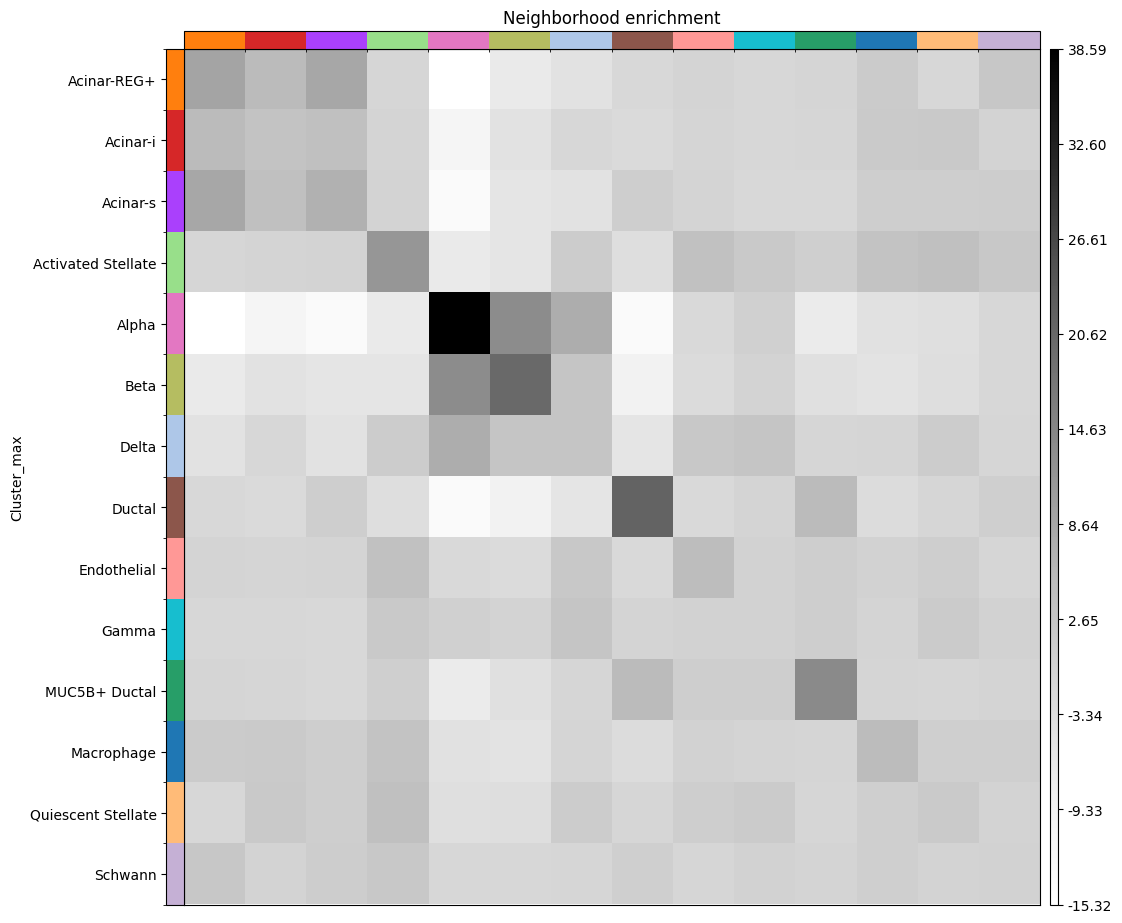

In [60]:
sq.pl.nhood_enrichment(adata_sp_fov_12, cluster_key='Cluster_max',cmap='Greys')

In [61]:
sq.gr.interaction_matrix(adata_sp_fov_12, cluster_key='Cluster_max',weights=True)

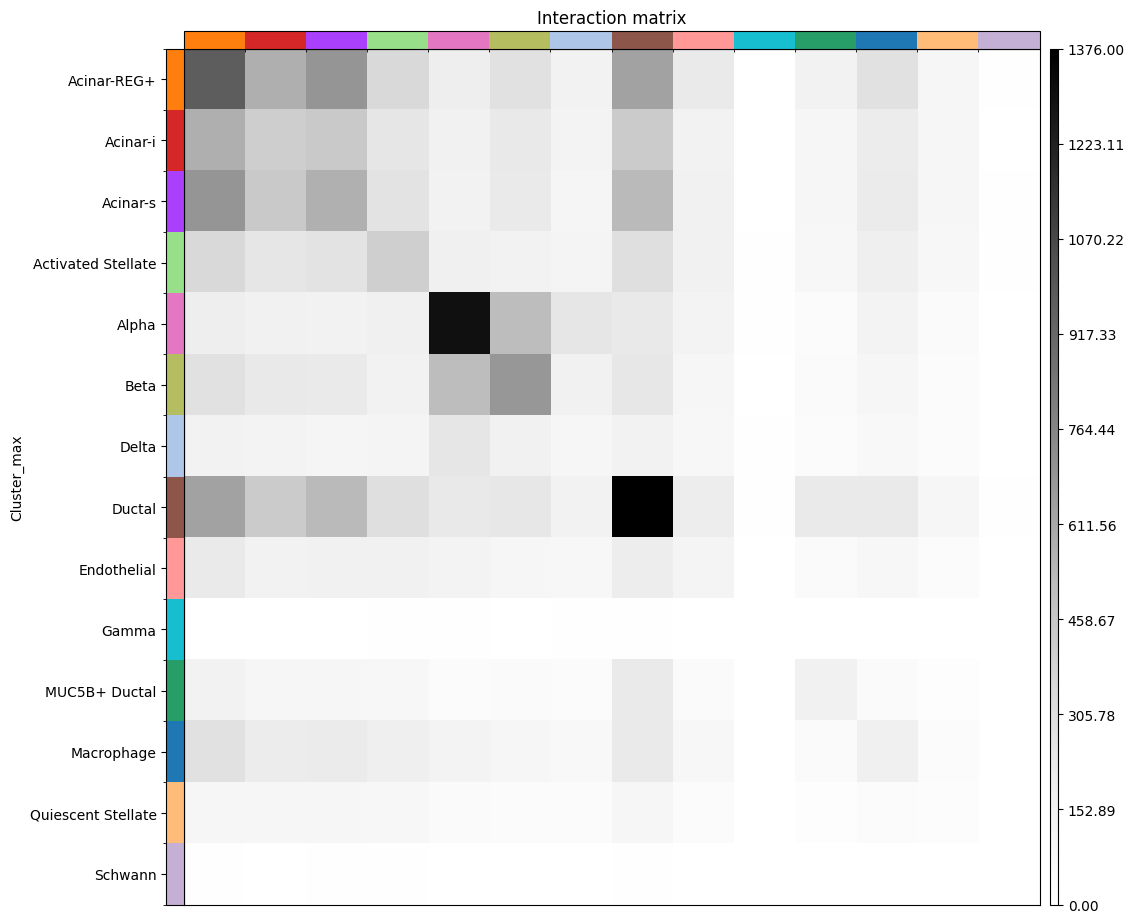

In [62]:
sq.pl.interaction_matrix(adata_sp_fov_12, cluster_key='Cluster_max',cmap='Greys')